In [276]:
import importlib 
import utils
import os
import json
importlib.reload(utils)

<module 'utils' from '/home/forrest/repos/FaithBench/assign/utils.py'>

In [277]:
result_path = 'batch_5_src_no_sports/results'
result_files = [os.path.join(result_path, f"batch_{batch_id}_annotation.json") for batch_id in list(range(1,10))
                #  + [11,12,13,14,15,16]
                 ]
skip_sample_ids = {os.path.join(result_path, "batch_5_annotation.json"): list(range(40,50))}
selected_annotators = {
        # os.path.join(result_path, "batch_3_annotation.json"): ['yujia', 'rogger'],
        os.path.join(result_path, "batch_7_annotation.json"): ['yujia', 'manveer']
}
num_annotators = {file_path:2 for file_path in result_files}
for i in [3,5]:
    num_annotators[os.path.join(result_path, f"batch_{i}_annotation.json")] = 3

halu_eval = utils.HaluEvaluator(result_files, halu_labels= ['Unwanted'], skip_sample_ids=skip_sample_ids, selected_annotators=selected_annotators, num_annotators=num_annotators)
halu_eval.process_results()

In [278]:
print(json.dumps(halu_eval.compute_halu_rate(), indent=2))

number of records for openai/GPT-3.5-Turbo: 44
number of records for openai/gpt-4o: 44
number of records for Qwen/Qwen2.5-7B-Instruct: 44
number of records for microsoft/Phi-3-mini-4k-instruct: 44
number of records for cohere/command-r-08-2024: 44
number of records for meta-llama/Meta-Llama-3.1-8B-Instruct: 44
number of records for meta-llama/Meta-Llama-3.1-70B-Instruct: 44
number of records for google/gemini-1.5-flash-001: 44
number of records for Anthropic/claude-3-5-sonnet-20240620: 44
number of records for mistralai/Mistral-7B-Instruct-v0.3: 44
{
  "openai/gpt-4o": 36.36,
  "openai/GPT-3.5-Turbo": 50.0,
  "Anthropic/claude-3-5-sonnet-20240620": 50.0,
  "meta-llama/Meta-Llama-3.1-70B-Instruct": 56.82,
  "google/gemini-1.5-flash-001": 56.82,
  "microsoft/Phi-3-mini-4k-instruct": 59.09,
  "meta-llama/Meta-Llama-3.1-8B-Instruct": 59.09,
  "Qwen/Qwen2.5-7B-Instruct": 68.18,
  "cohere/command-r-08-2024": 75.0,
  "mistralai/Mistral-7B-Instruct-v0.3": 75.0
}


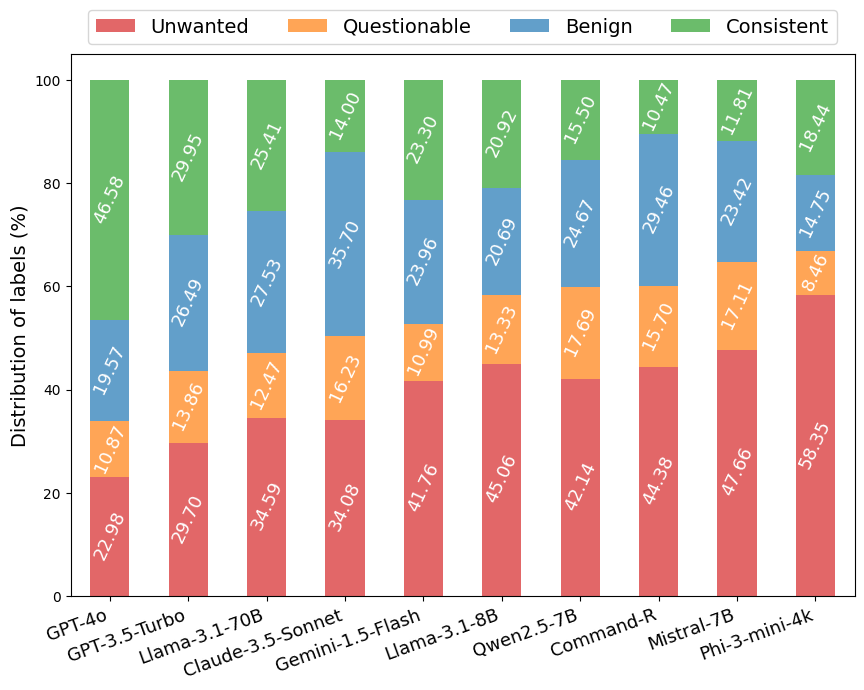

In [279]:
halu_eval.get_halu_dist()

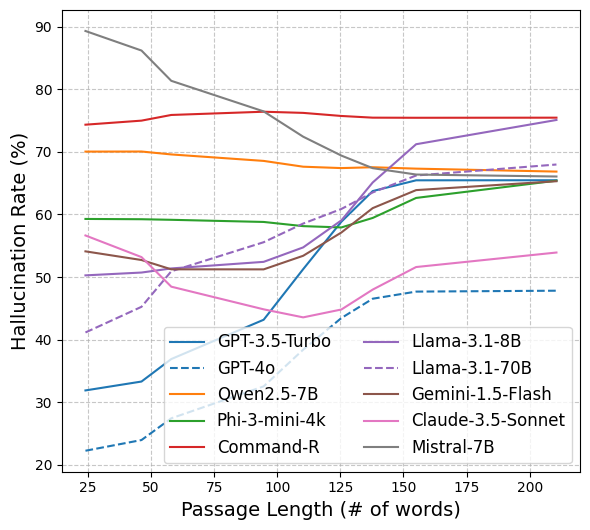

In [280]:
halu_eval.halu_vs_length('source')

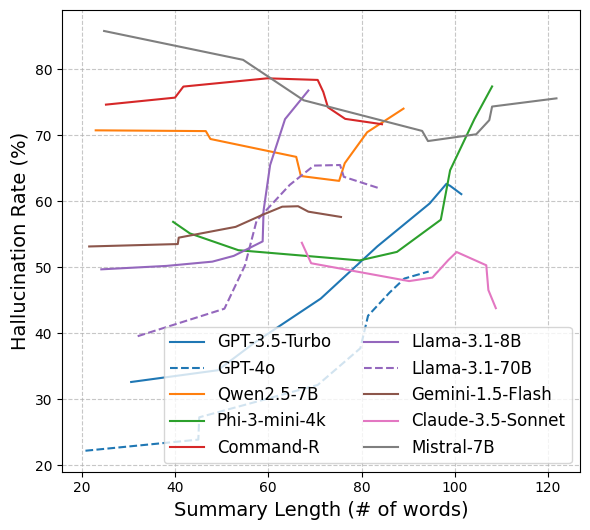

In [281]:
halu_eval.halu_vs_length('summary')

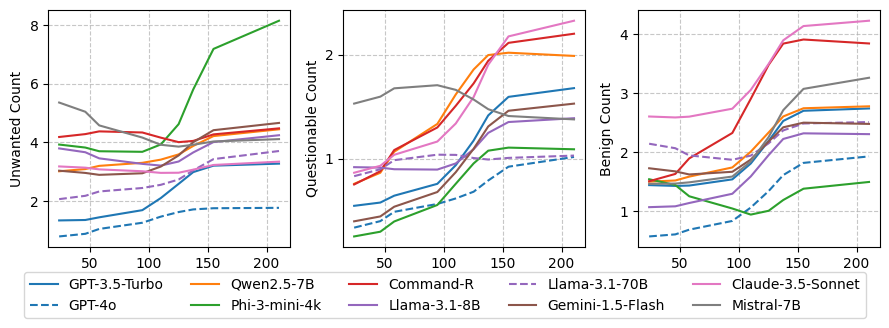

In [282]:
# halu_eval.halu_length(halu_labels=['Unwanted', 'Questionable'])
halu_eval.label_vs_length(mode = 'count', length_of='source')

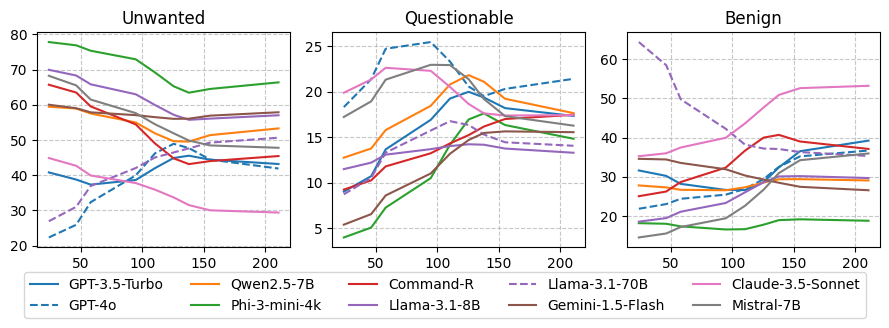

In [283]:
halu_eval.label_vs_length(mode = 'ratio', length_of='source')